<a href="https://colab.research.google.com/github/NJain121442/course2020/blob/master/HW2_part_2_denoise_cats_Nikita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.patches as patches
from skimage.draw import random_shapes


In [2]:
!wget -O cats.npy https://www.dropbox.com/s/epykavp5x5e03e2/cats.npy?dl=0

--2020-06-08 20:37:22--  https://www.dropbox.com/s/epykavp5x5e03e2/cats.npy?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/epykavp5x5e03e2/cats.npy [following]
--2020-06-08 20:37:23--  https://www.dropbox.com/s/raw/epykavp5x5e03e2/cats.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc15cc5879354ea365ed70734058.dl.dropboxusercontent.com/cd/0/inline/A5QcaTEmSntUpfa1kkYLuh03bUSDA4TS1AwbJaRy0QnD2iBWpd4_sSXO_bJpwoUL3N46wFwYyUy1DdMQQVRqY_dNz3akyqAY1OYi3AKc5qhHFlfjZnAobwf-EPpS4VN_AK0/file# [following]
--2020-06-08 20:37:23--  https://uc15cc5879354ea365ed70734058.dl.dropboxusercontent.com/cd/0/inline/A5QcaTEmSntUpfa1kkYLuh03bUSDA4TS1AwbJaRy0QnD2iBWpd4_sSXO_bJpwoUL3N46wFwYyUy1DdMQQVRqY_dNz3akyqAY1OYi3AKc5qhHFlfjZnAobw

# Homework 2, part 2

1. below you will find a dataloader for the cats dataset (link to dataset file on the course website)

2. the function to add noise to the dataset is built into the dataloader

3. build a model that takes in the 256x256 image, and outputs an image of the same size 

4. use the nn.MSELoss() function

5. train the network

6. submit when you feel your network is doing a decent job at cleaning the images (remember to submit both model weights and source code)

In [0]:
path = '/content/cats.npy'

In [0]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


class CustomDataset(Dataset):
    def __init__(self, path,start_idx, end_idx):
        
        self.data = np.load(path)
        self.data = self.data[start_idx:end_idx]

    def __len__(self):
       
        return len(self.data)
    
    def add_noise(self,y):
        newimg = random_shapes((256, 256),min_shapes=30,max_shapes=42,
                       multichannel=False, min_size=20,max_size=30,allow_overlap=True)[0]/255.0
        x = y.copy()
        x[np.where(newimg < 0.9)] = x[np.where(newimg < 0.9)]+1-newimg[newimg < 0.9]
        return x

    def __getitem__(self, idx):
        
        y = self.data[idx]

        x = torch.FloatTensor(self.add_noise(y)).unsqueeze(0)
        
        return x, torch.FloatTensor(y).unsqueeze(0)

In [0]:
loss_func = nn.MSELoss()

In [6]:
train_ds = CustomDataset('cats.npy',0,800)
valid_ds = CustomDataset('cats.npy',800,1000)
training_dataloader = DataLoader(train_ds,batch_size=1)
valid_dataloader = DataLoader(valid_ds,batch_size=1)
training_tensor = torch.stack([train_ds[i][0] for i in range(len(train_ds)) ])
training_clean_image = train_ds.data
validation_tensor = torch.stack([valid_ds[i][0] for i in range(len(valid_ds)) ])
validation_clean_image = valid_ds.data
len(training_dataloader)

800

In [0]:
x, y = train_ds[444]

In [8]:
y.shape

torch.Size([1, 256, 256])

In [9]:
x.shape

torch.Size([1, 256, 256])

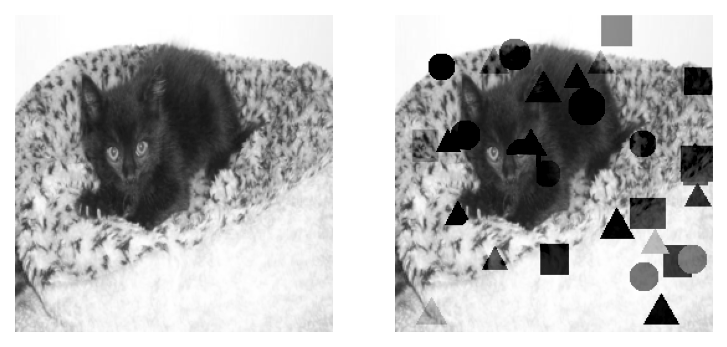

In [10]:
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].imshow(y[0],cmap='gist_yarg',vmin=0,vmax=1)
ax[1].imshow(x[0],cmap='gist_yarg',vmin=0,vmax=1)

for i in range(2):
    ax[i].set_axis_off()

plt.show()

In [0]:
conv_layer = nn.Conv2d(1,512,5,padding=2)

In [12]:
batch_of_one = x.unsqueeze(0)

batch_of_one.shape

torch.Size([1, 1, 256, 256])

In [13]:
conv_layer(batch_of_one).shape

torch.Size([1, 512, 256, 256])

In [0]:
class Denoise(nn.Module):

    def __init__(self):
        super(Denoise, self).__init__()
        self.conv_layer1 = nn.Conv2d(1,512,3,padding=1)
        self.conv_layer2 = nn.Conv2d(512,128,3,padding=1)
        self.conv_layer3 = nn.Conv2d(128,32,3,padding=1)
        self.conv_layer4 = nn.Conv2d(32,1,3,padding=1)
    def forward(self, x):
        out = F.relu(self.conv_layer1(x))
        out = F.relu(self.conv_layer2(out))
        out = F.relu(self.conv_layer3(out))
        out = self.conv_layer4(out)
        return out  

In [0]:
net = Denoise()
import torch.cuda
if torch.cuda.is_available():
    net.cuda()

In [0]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01) 

In [17]:
from tqdm.notebook import tqdm

n_epochs = 50

loss_vs_epoch = []

for epoch in tqdm( range(n_epochs) ):
  print(epoch)
  training_loss = 0
  validation_loss =0
  net.train()
  for x,y in training_dataloader:
    if torch.cuda.is_available():
      x,y = x.cuda(),y.cuda()
      #clear the grade of all optimzed variables 
      optimizer.zero_grad()
      output = net(x)
      #calculate the loss 
      loss = loss_func(output,y)
      loss.backward()
      optimizer.step()
      print(loss.item())
      training_loss += loss.item()
    
  net.eval()
  for x,y in valid_dataloader:
    if torch.cuda.is_available():
      x,y = x.cuda(),y.cuda()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = net(x)   # calculate the loss
      loss = loss_func(output,y) # update running validation loss 
      validation_loss += loss.item()

  loss_vs_epoch.append([training_loss/len(train_ds), validation_loss/len(valid_ds)])

Streaming output truncated to the last 5000 lines.
0.011948377825319767
0.008352442644536495
0.019237156957387924
0.01426345482468605
0.02170410379767418
0.008713584393262863
0.00948387198150158
0.012390848249197006
0.017620962113142014
0.011352619156241417
0.009248670190572739
0.007241684012115002
0.010131865739822388
0.016723711043596268
0.013308251276612282
0.007654360495507717
0.01775328256189823
0.008732711896300316
0.005439511965960264
0.005987454671412706
0.017915068194270134
0.010816561989486217
0.005277856253087521
0.008233312517404556
0.012544010765850544
0.007249034009873867
0.016691703349351883
0.007839314639568329
0.01377823855727911
0.018624428659677505
0.009148487821221352
0.009592493996024132
0.021982233971357346
0.007238680496811867
0.013765507377684116
0.01418109331279993
0.010520423762500286
0.006753257475793362
0.009984140284359455
0.02173413708806038
0.006587970070540905
0.005614114925265312
0.007957407273352146
0.006737169809639454
0.009123481810092926
0.011563144

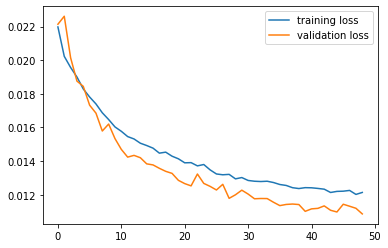

In [18]:
loss_vs_epoch = np.array(loss_vs_epoch)

plt.plot(loss_vs_epoch[:,0][1:],label='training loss')
plt.plot(loss_vs_epoch[:,1][1:],label='validation loss')

plt.legend()

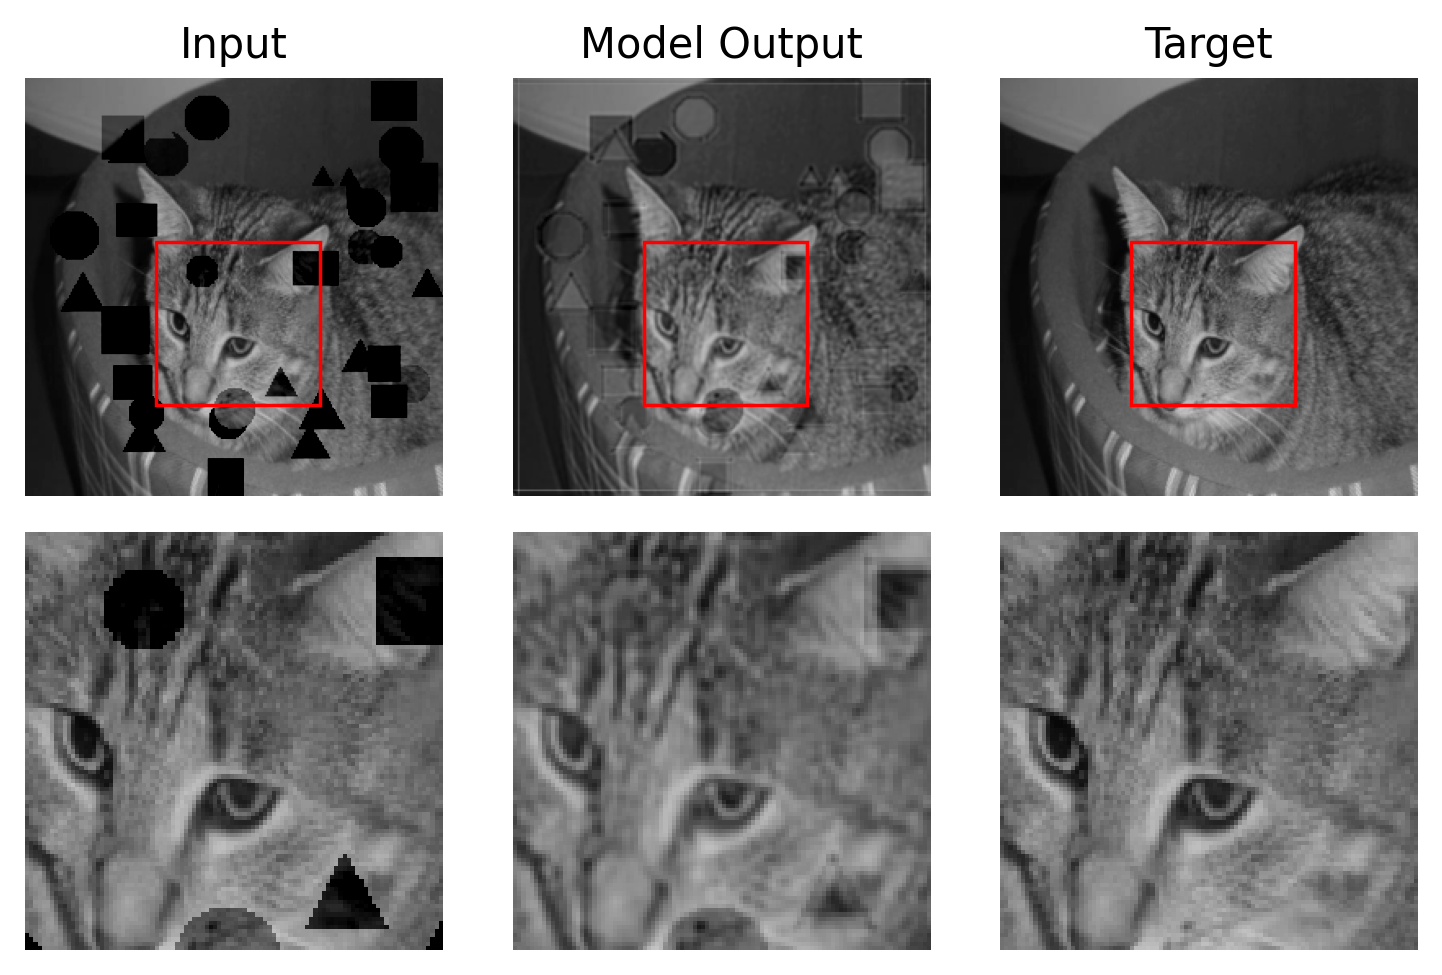

In [24]:
x, y = valid_ds[120]

fig,ax = plt.subplots(2,3,figsize=(6,(6/3)*2),dpi=250)

net.cpu()
net.eval()

input_img = x[0]
model_pred = net(x.unsqueeze(0))[0].cpu().data.numpy()[0]

ground_truth = y[0]

patch_xy = [80,100]
patch_hw = [100,100]


ax[0][0].set_title('Input',fontsize=12)
ax[0][1].set_title('Model Output',fontsize=12)
ax[0][2].set_title('Target',fontsize=12)

ax[0][0].imshow(input_img,cmap='gist_yarg',vmin=0,vmax=1)
ax[0][1].imshow(model_pred,cmap='gist_yarg',vmin=0,vmax=1)
ax[0][2].imshow(ground_truth,cmap='gist_yarg',vmin=0,vmax=1)


for i in range(0,3):
    rect = patches.Rectangle(patch_xy,patch_hw[0],patch_hw[1],linewidth=1,edgecolor='r',facecolor='none')
    ax[0][i].add_patch(rect)


input_img    = input_img[patch_xy[1]:patch_xy[1]+patch_hw[1],patch_xy[0]:patch_xy[0]+patch_hw[0]] 
model_pred   = model_pred[patch_xy[1]:patch_xy[1]+patch_hw[1],patch_xy[0]:patch_xy[0]+patch_hw[0]]    
ground_truth = ground_truth[patch_xy[1]:patch_xy[1]+patch_hw[1],patch_xy[0]:patch_xy[0]+patch_hw[0]] 


ax[1][0].imshow(input_img,cmap='gist_yarg',vmin=0,vmax=1)
ax[1][1].imshow(model_pred,cmap='gist_yarg',vmin=0,vmax=1)
ax[1][2].imshow(ground_truth,cmap='gist_yarg',vmin=0,vmax=1)


for i in range(3):
    for j in range(2):
        ax[j][i].set_axis_off()

plt.tight_layout()
plt.show()

In [0]:
torch.save(net.state_dict(), '/content/Denoise_model.pt')

In [21]:
from google.colab import files
files.download("/content/Denoise_model.pt")

MessageError: ignored